In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import glob
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


2024-12-15 16:47:28.988671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("BreaKHis_v1/histology_slides/breast/image_data.csv")

# Extract image-related information from the path column if it exists
if 'path_to_image' in df.columns:
    df['image_name'] = df['path_to_image'].apply(lambda x: os.path.basename(x))
    #df = df.drop(columns=['path_to_image'])

print(df.head())


                                       path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
3  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
4  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification                      image_name  
0    Adenosis          100X  SOB_B_A-14-22549AB-100-011.png  
1    Adenosis          100X  SOB_B_A-14-22549AB-100-005.png  
2    Adenosis          100X  SOB_B_A-14-22549AB-100-004.png  
3    Adenosis          100X  SOB_B_A-14-22549AB-100-010.png  
4    Adenosis          100X  SOB_B_A-14-22549AB-100-006.png  


#### Exploration Data Analysis

##### Vectorize images

In [3]:
image_data = []

for index, row in df.iterrows():
    img = load_img(row['path_to_image'], target_size=(150, 150, 3))
    img_array = img_to_array(img)  
    image_data.append(img_array)

df['image_data'] = image_data

In [4]:
df['image_data'].head()

0    [[[183.0, 170.0, 196.0], [168.0, 157.0, 199.0]...
1    [[[177.0, 164.0, 173.0], [192.0, 146.0, 175.0]...
2    [[[202.0, 212.0, 204.0], [189.0, 172.0, 191.0]...
3    [[[206.0, 213.0, 205.0], [207.0, 212.0, 208.0]...
4    [[[152.0, 144.0, 168.0], [158.0, 143.0, 176.0]...
Name: image_data, dtype: object

##### Check for duplicated images

##### Check dataset distribution

In [5]:
# Display dataset summary
print(f"Dataset contains {len(df)} images.")

# Calculate raw counts and percentages
tumor_summary = df["Benign or Malignant"].value_counts().reset_index()
tumor_summary.columns = ["Benign or Malignant", "Count"]
tumor_summary["Percentage (%)"] = round((tumor_summary["Count"] / len(df)) * 100, 2)

# Summary of tumor classes and types
print("\nSummary of tumor classes:")
print(tumor_summary)

print("\nSummary of tumor types:")
print(df[["Benign or Malignant","Cancer Type"]].value_counts())

Dataset contains 7909 images.

Summary of tumor classes:
  Benign or Malignant  Count  Percentage (%)
0           Malignant   5426           68.61
1              Benign   2480           31.36

Summary of tumor types:
Benign or Malignant  Cancer Type        
Malignant            Ductal Carcinoma       3450
Benign               Fibroadenoma           1014
Malignant            Mucinous Carcinoma      789
                     Lobular Carcinoma       626
Benign               Tubular Adenoma         569
Malignant            Papillary Carcinoma     560
Benign               Phyllodes Tumor         453
                     Adenosis                444
Name: count, dtype: int64


/var/folders/x3/sldfx88s0r38rjmf6v0l9v7r0000gp/T/ipykernel_5402/2926125085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=benign_grouped, x='Magnification', y='Count', palette='viridis')


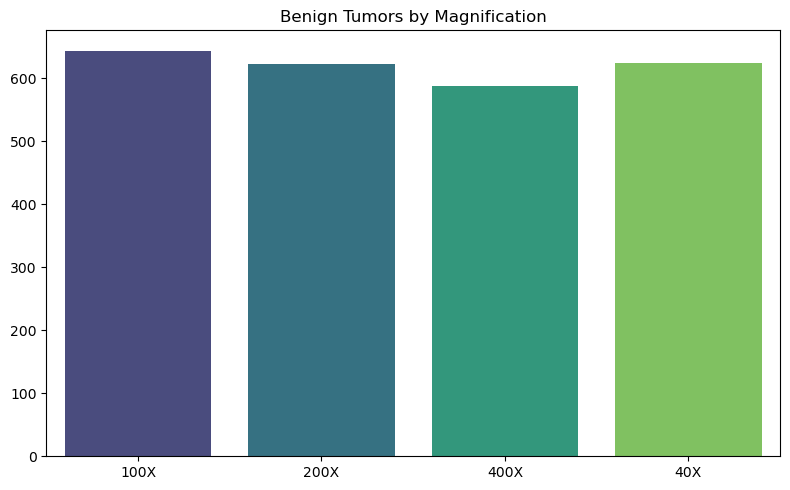

/var/folders/x3/sldfx88s0r38rjmf6v0l9v7r0000gp/T/ipykernel_5402/2926125085.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=malignant_grouped, x='Magnification', y='Count', palette='viridis')


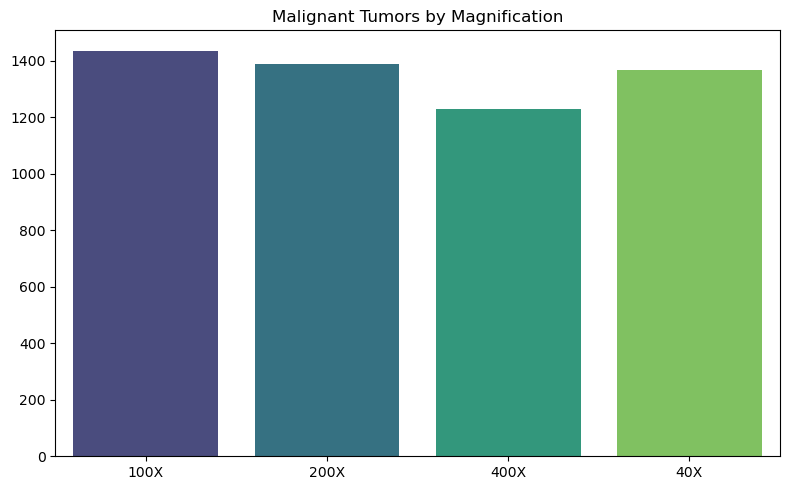

In [6]:
benign_data = df[df['Benign or Malignant'] == 'Benign']
malignant_data = df[df['Benign or Malignant'] == 'Malignant']

# Group for Benign tumors
benign_grouped = benign_data.groupby('Magnification').size().reset_index(name='Count')

# Group for Malignant tumors
malignant_grouped = malignant_data.groupby('Magnification').size().reset_index(name='Count')

# Plot for Benign tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=benign_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Benign Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot for Malignant tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=malignant_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Malignant Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Binary classification

#### Target variable and Train, test split

In [7]:
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

In [8]:
df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training and testing subsets
#X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state = 1, shuffle = True)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state = 1, stratify=y_train, shuffle=True)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### Models

#### Model 1
##### 2 hidden layers with 16 hidden units each

In [12]:
# Build the Sequential model
model = Sequential()

# First hidden layer with input_dim specified
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7199 - loss: 2.6830 - val_accuracy: 0.7462 - val_loss: 1.0778
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8399 - loss: 0.8194 - val_accuracy: 0.7867 - val_loss: 0.9737
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8591 - loss: 0.5832 - val_accuracy: 0.8103 - val_loss: 1.5856
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9032 - loss: 0.4101 - val_accuracy: 0.7875 - val_loss: 1.2955
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9209 - loss: 0.2707 - val_accuracy: 0.8052 - val_loss: 1.3776
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9379 - loss: 0.2029 - val_accuracy: 0.8120 - val_loss: 1.6291
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9531 - loss: 0.1791 - val_accuracy: 0.8044 - val_loss: 1.8432
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9561 - loss: 0.1610 - val_ac

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │     1,080,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,160,612 (8.24 MB)

 Trainable params: 1,080,305 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,080,307 (4.12 MB)

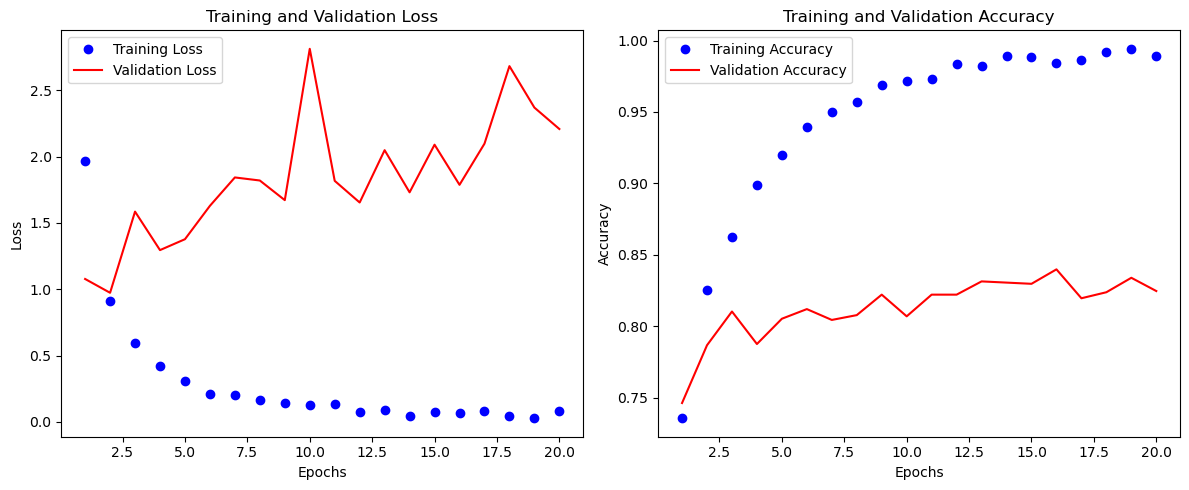

In [14]:
# Extracting data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [15]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 2.4798
Test Accuracy: 0.8130


In [16]:
# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Sample Predictions (Probability -> Binary):
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 0
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.0000, Predicted Class: 0, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.9999, Predicted Class: 1, Actual Class: 1



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       372
           1       0.85      0.88      0.87       815

    accuracy                           0.81      1187
   macro avg       0.78      0.77      0.78      1187
weighted avg       0.81      0.81      0.81      1187


ROC-AUC Score: 0.8490


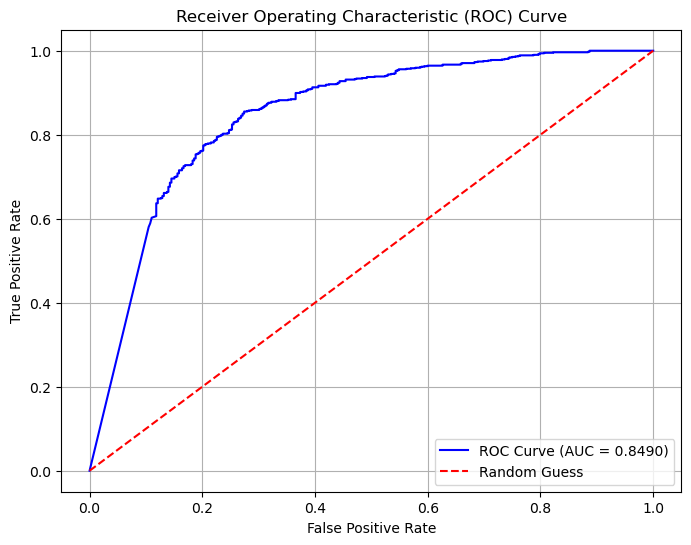

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 2
##### 3 hidden layers with 16 hidden units each
##### Tested 3 hidden layers with 32 units each, but the results were unsatisfactory

In [18]:
# Build the Sequential model
model_2 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_2.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model_2.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Third hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Output layer for binary classification
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5720 - loss: 3.0291 - val_accuracy: 0.7403 - val_loss: 0.7034
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7903 - loss: 0.6717 - val_accuracy: 0.7631 - val_loss: 0.6455
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8467 - loss: 0.4577 - val_accuracy: 0.7639 - val_loss: 0.8690
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8798 - loss: 0.3639 - val_accuracy: 0.8212 - val_loss: 0.5691
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9105 - loss: 0.2744 - val_accuracy: 0.8170 - val_loss: 0.7174
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9177 - loss: 0.2898 - val_accuracy: 0.8145 - val_loss: 0.6632
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9403 - loss: 0.1801 - val_accuracy: 0.8153 - val_loss: 1.0068
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9502 - loss: 0.1451 - val_accu

In [19]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │     1,080,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,161,156 (8.24 MB)

 Trainable params: 1,080,577 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,080,579 (4.12 MB)

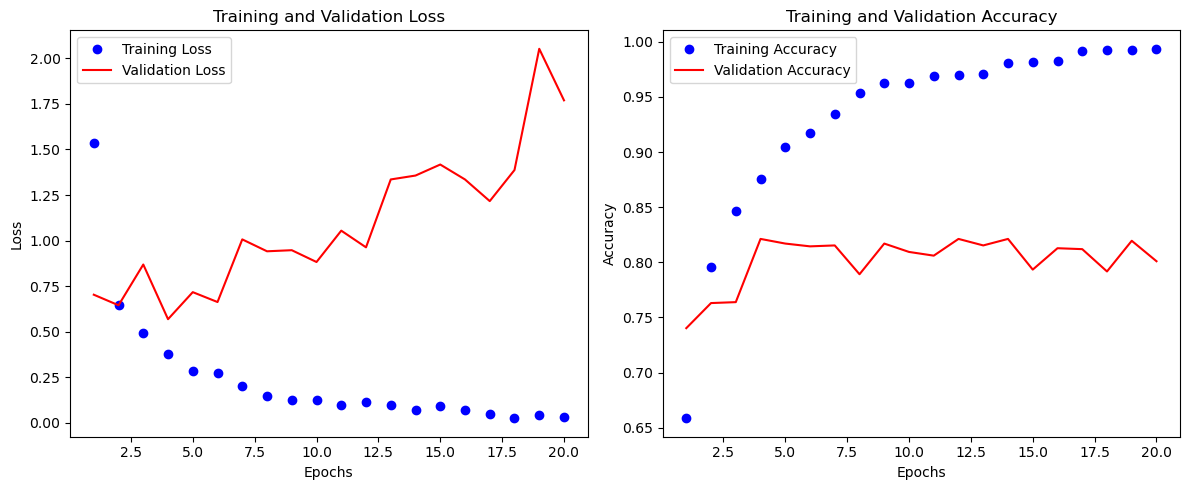

In [20]:
# Extracting data from the history object
history_dict = history_2.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [21]:
# Evaluate the model on the test data
results = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 1.9677
Test Accuracy: 0.8062


In [22]:
# Generate predictions
y_pred_prob = model_2.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Sample Predictions (Probability -> Binary):
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 0
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.0000, Predicted Class: 0, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       372
           1       0.85      0.87      0.86       815

    accuracy                           0.81      1187
   macro avg       0.78      0.77      0.77      1187
weighted avg       0.80      0.81      0.80      1187


ROC-AUC Score: 0.8562


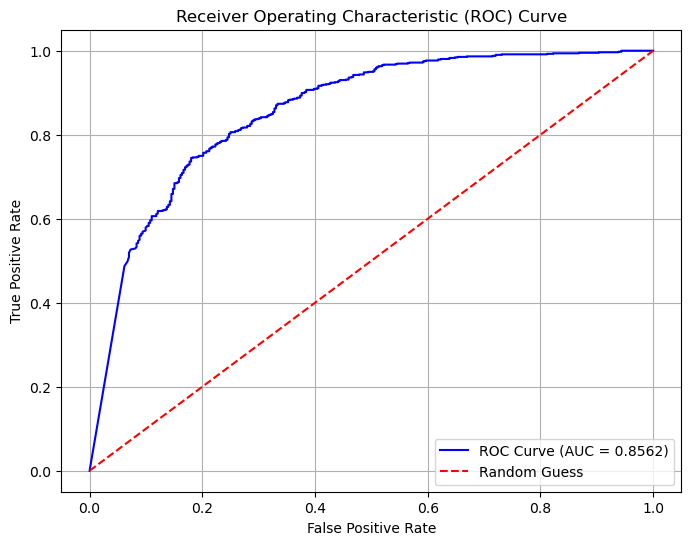

In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 3
##### Equivalent to model 2 but with the loss function mse instead
##### Also tried tanh activation function 

In [24]:
# Build the Sequential model
model_3 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_3.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model_3.add(Dense(16, activation='tanh', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Third hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Output layer for binary classification
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7246 - loss: 0.1846 - val_accuracy: 0.7968 - val_loss: 0.1462
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8105 - loss: 0.1409 - val_accuracy: 0.7985 - val_loss: 0.1426
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8138 - loss: 0.1359 - val_accuracy: 0.8044 - val_loss: 0.1409
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8271 - loss: 0.1302 - val_accuracy: 0.8027 - val_loss: 0.1409
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8194 - loss: 0.1325 - val_accuracy: 0.7993 - val_loss: 0.1368
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8345 - loss: 0.1222 - val_accuracy: 0.8069 - val_loss: 0.1355
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8242 - loss: 0.1283 - val_accuracy: 0.8035 - val_loss: 0.1418
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8287 - loss: 0.1252 - val_accu

In [25]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 16)             │     1,080,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,161,156 (8.24 MB)

 Trainable params: 1,080,577 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,080,579 (4.12 MB)

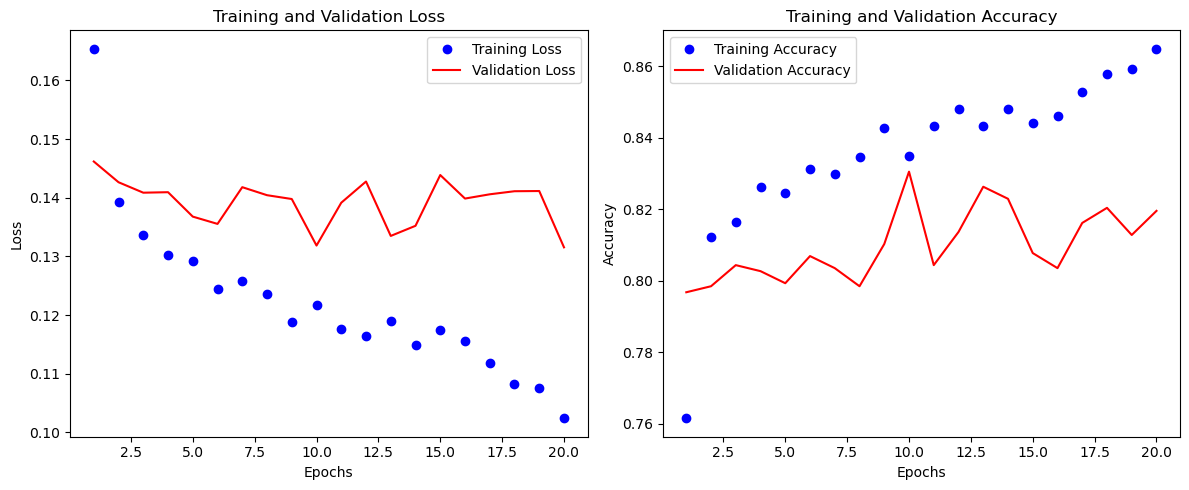

In [26]:
# Extracting data from the history object
history_dict = history_3.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [27]:
# Evaluate the model on the test data
results = model_3.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 0.1363
Test Accuracy: 0.8071


In [28]:
# Generate predictions
y_pred_prob = model_3.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.8495, Predicted Class: 1, Actual Class: 1
Probability: 0.9117, Predicted Class: 1, Actual Class: 1
Probability: 0.9782, Predicted Class: 1, Actual Class: 1
Probability: 0.5824, Predicted Class: 1, Actual Class: 1
Probability: 0.9472, Predicted Class: 1, Actual Class: 1
Probability: 0.9260, Predicted Class: 1, Actual Class: 0
Probability: 0.9883, Predicted Class: 1, Actual Class: 1
Probability: 0.0510, Predicted Class: 0, Actual Class: 1
Probability: 0.3848, Predicted Class: 0, Actual Class: 1
Probability: 0.9326, Predicted Class: 1, Actual Class: 1



Classification Report:


              precision    recall  f1-score   support

           0       0.76      0.56      0.64       372
           1       0.82      0.92      0.87       815

    accuracy                           0.81      1187
   macro avg       0.79      0.74      0.76      1187
weighted avg       0.80      0.81      0.80      1187


ROC-AUC Score: 0.8520


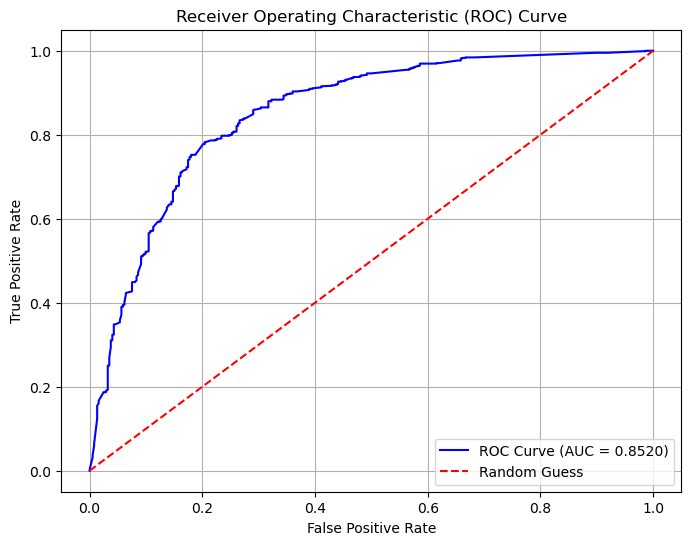

In [29]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 4
##### CNN implementation

In [6]:
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array

# Normalize the image data (pixel values between 0 and 1)
X = X / 255.0  # Scale pixel values to [0, 1]

df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training (70%), testing (15%), and validation (15%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=1, shuffle=True)

# Verify the shapes of the splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (5536, 150, 150, 3), (5536,)
Validation data shape: (1186, 150, 150, 3), (1186,)
Test data shape: (1187, 150, 150, 3), (1187,)


In [30]:
'''
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
#X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
'''

"\nX = np.array(df['image_data'].tolist())  # Convert Series to a numpy array\n# Flatten X (from 3D to 2D)\n#X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector\n\nX_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)\n\n# Scale the features\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\nX_val = scaler.transform(X_val)\n"

In [7]:
# Build the CNN model
model_4 = Sequential()

# First convolutional layer
model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(125, 125, 3)))  # Example input shape for 64x64 RGB images
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model_4.add(Flatten())

# Fully connected layers
model_4.add(Dense(64, activation='relu'))  # First dense layer
model_4.add(Dense(16, activation='relu'))  # Second dense layer

# Output layer for binary classification
model_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='mse',  # Note: Binary crossentropy is generally better for binary classification
                metrics=['accuracy'])

# Train the model
model_4 = model_4.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 21632, but received input with shape (None, 36992)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 150, 150, 3), dtype=float32)
  • training=True
  • mask=None

### Pre-trained models

In [31]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model.trainable = False

# Add custom layers for binary or multi-class classification
model_ResNet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification
])

# Compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall']) #binary
#model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='crossentropy', metrics=['accuracy','precision','recall']) #multiclass

In [32]:
model_ResNet50.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32) #analisar train e test

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 67500), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 67500), dtype=float32)
  • training=True
  • mask=None

In [36]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 67500), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 67500), dtype=float32)
  • training=False
  • mask=None

In [44]:
# Load VGG16 without the top layer (pre-trained on ImageNet)
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model_vgg16.trainable = False

# Add custom layers for binary or multi-class classification
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification (e.g., 8 cancer types)
])

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [45]:
model_vgg16.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 67500), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 67500), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Predict and evaluate
y_pred_vgg16 = model_vgg16.predict(X_test)
y_pred_vgg16 = np.round(y_pred_vgg16)
print(classification_report(y_test, y_pred_vgg16))
print(confusion_matrix(y_test, y_pred_vgg16))